<a href="https://colab.research.google.com/github/enerhy/Portfolio/blob/master/Steel_Defect_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This Notebook provides a solution for the [Severstal: Steel Defect Detection Competition](https://www.kaggle.com/c/severstal-steel-defect-detection). 

**The Problem:** Severstal manufactures flat sheet steel. The sheets can have different defects. The goal of this competition and of the Kernel is to create an algorithm to enhance defect detection and localization, where a sheet might have multiple different defects.

**The Data:** There are 6666 images provided of stell sheets having one or multiple defects.

**Aproach:** Use of a UNET Segmentation model with pretrained encoding weights. The Backbone of the model is a ResNet34. To allow image loading an Image Data Generator is used. In this notebook I reproduce the work in this [Kernel](https://www.kaggle.com/cdeotte/keras-unet-with-eda). Moreover, I used Dice/ Jaccard Loss to compare the results with a Binary Crossentropy and incorporated code changes related to amendments in the Dataset and its Structure. The pretrained model used can be found [here](https://github.com/qubvel/segmentation_models)

**The result:** Although the model has been trained on just 10 epochs, it converges based on the choosen loss function in the Train and in the Validation set. Choosing a threshold (certainty of the model to have detected a defect of a certain type in a single pixel) is a todo for a future work. However, with a threshold of 50% 2/3 of the samples were correctyl identified and classified. On another hand only 2 of the 32 samples were incorrectly identified.

# Imports and SetUp

In [1]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=f28dddc8a30c351995ae96c10f58907ed8efd7f24c6885cfa9c45547124d636b
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 26.3 GB  | Proc size: 158.7 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


In [0]:
a = []
while(1):
    a.append('1')

In [0]:
# !pip uninstall tensorflow
# pip uninstall tensorflow-gpu==1.15

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

2.2.0-rc3


In [0]:
import numpy as np
import pandas as pd
import os
import gc
import time 
import matplotlib.pyplot as plt
import warnings
from PIL import Image
warnings.filterwarnings('ignore')

import seaborn as sns

In [4]:
! pip install segmentation-models

In [5]:
# It is important to place the data into the system path since loading images
# from drive is very slow
from zipfile import ZipFile
file_name = '/content/drive/My Drive/Colab Notebooks/Steel/severstal-steel-defect-detection.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [0]:
train = pd.read_csv('train.csv')

In [7]:
train.head()

ImageId  ClassId                                      EncodedPixels
0  0002cc93b.jpg        1  29102 12 29346 24 29602 24 29858 24 30114 24 3...
1  0007a71bf.jpg        3  18661 28 18863 82 19091 110 19347 110 19603 11...
2  000a4bcdd.jpg        1  37607 3 37858 8 38108 14 38359 20 38610 25 388...
3  000f6bf48.jpg        4  131973 1 132228 4 132483 6 132738 8 132993 11 ...
4  0014fce06.jpg        3  229501 11 229741 33 229981 55 230221 77 230468...

In [8]:
train.ClassId.value_counts()

3    5150
1     897
4     801
2     247
Name: ClassId, dtype: int64

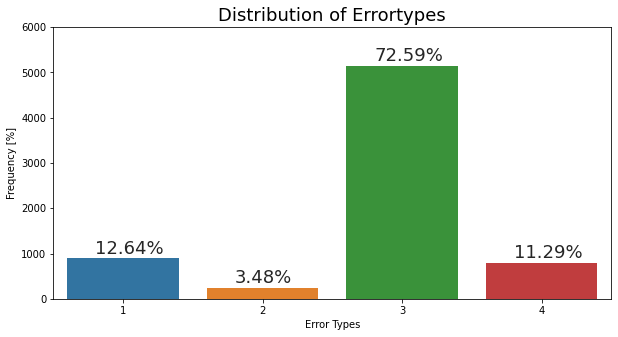

In [9]:
# Distribution of Errors in the dataset
ax = sns.countplot(x='ClassId', data=train)
sns.set(font_scale=1.5)
ax.set_xlabel(' ')
ax.set_ylabel(' ')
fig = plt.gcf()
fig.set_size_inches(10,5)
ax.set_ylim(top=6000)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height()/len(train.ImageId)), (p.get_x()+ 0.2, p.get_height()+100))

plt.title('Distribution of Errortypes')
plt.xlabel('Error Types')
plt.ylabel('Frequency [%]')
plt.show()

In [0]:
train.ImageId.value_counts().value_counts()

1    6239
2     425
3       2
Name: ImageId, dtype: int64

# Preprocessing and Data Preparation


## RESTRUCTURE TRAIN DATAFRAME

In [10]:
"""In the target struccture, each defect is a separate feature and there is
one raw for each image"""

train[['e1', 'e2', 'e3', 'e4']] = pd.get_dummies(train.ClassId)
train.drop('ClassId', axis=1, inplace=True)

train['e1'] = np.where(train['e1'] == 1, train['EncodedPixels'], np.nan)
train['e2'] = np.where(train['e2'] == 1, train['EncodedPixels'], np.nan)
train['e3'] = np.where(train['e3'] == 1, train['EncodedPixels'], np.nan)
train['e4'] = np.where(train['e4'] == 1, train['EncodedPixels'], np.nan)

train.drop('EncodedPixels', axis=1, inplace=True)

aggregation_functions = {'ImageId': 'first', 'e1': 'first', 'e2': 'first', 'e3': 'first', 'e4': 'first'}
train = train.groupby(train['ImageId']).aggregate(aggregation_functions)
train.reset_index(drop=True, inplace=True)

train['count'] = train.count(axis=1) - 1

print(len(train))
train.head(10)

6666


ImageId  ... count
0  0002cc93b.jpg  ...     1
1  0007a71bf.jpg  ...     1
2  000a4bcdd.jpg  ...     1
3  000f6bf48.jpg  ...     1
4  0014fce06.jpg  ...     1
5  0025bde0c.jpg  ...     2
6  002af848d.jpg  ...     1
7  002fc4e19.jpg  ...     2
8  0030401a5.jpg  ...     1
9  0046839bd.jpg  ...     1

[10 rows x 6 columns]

## DataGenerator

DataGenerator is used to fetch data in batches while training. In this way the data is not loaded at filling up the memory. Example of creating and using DataGenerator can be find [here](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly)

In [11]:
import keras

class DataGenerator(keras.utils.Sequence):
    def __init__(self, df, batch_size = 16, subset='train', shuffle=False,
                preprocess=None, info={}):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.subset = subset
        self.batch_size = batch_size
        self.preprocess = preprocess
        self.info = info
        
        if self.subset == 'train':
            self.data_path = 'train_images/'
        elif self.subset == 'test':
            self.data_path = 'test_images/'
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __getitem__(self, index):
        X = np.empty((self.batch_size, 128, 800, 3), dtype=np.float32)
        y = np.empty((self.batch_size, 128, 800, 4), dtype=np.int8)
        '''The label array has 4 channels corresponding to the 4 masks that will be created
        coresponding to the 4 types of errors???'''
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        for i, f in enumerate(self.df['ImageId'].iloc[indexes]):
            self.info[index*self.batch_size+i]=f
            X[i,] = Image.open(self.data_path + f).resize((800, 128))
            if self.subset == 'train':
                for j in range(4):
                    y[i,:,:,j] = rle2maskResize(self.df['e'+str(j+1)].iloc[indexes[i]])
                    
        if self.preprocess!=None: X = self.preprocess(X)
        
        if self.subset == 'train': return X, y
        else: return X

Using TensorFlow backend.


## Utility Functions

There are three utility functions handling the creation of masks.
* 1st: Converts RLE to a mask
* 2nd: Enladges the mask to exceed the defect's area
* 3nd: Converts a mask to a boarded mask

In [0]:
def rle2maskResize(rle):
    # CONVERT RLE TO MASK 
    # where rle is just the string of all error pixel places for an error type
    if (pd.isnull(rle))|(rle==''): 
        return np.zeros((128,800) ,dtype=np.uint8)
    
    # Here we create an empty mask
    height= 256
    width = 1600
    mask= np.zeros( width*height ,dtype=np.uint8)

    # Here we create an array representing the mask
    array = np.asarray([int(x) for x in rle.split()])
    '''the mask starts with 1 pixel befor the error???'''
    # contains the starting point for each arrea
    starts = array[0::2]-1
    # contains the length of the error line (number of consequent pixels)
    lengths = array[1::2]    
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
    
    # where order F means columnwise ordering/ C is default meaning
    # row wise ordering
    return mask.reshape( (height,width), order='F' )[::2,::2]

In [0]:
def mask2contour(mask, width=3):
    # CONVERT MASK TO ITS CONTOUR
    w = mask.shape[1]
    h = mask.shape[0]
    mask2 = np.concatenate([mask[:,width:],np.zeros((h,width))],axis=1)
    mask2 = np.logical_xor(mask,mask2)
    mask3 = np.concatenate([mask[width:,:],np.zeros((width,w))],axis=0)
    mask3 = np.logical_xor(mask,mask3)
    return np.logical_or(mask2,mask3) 

In [0]:
def mask2pad(mask, pad=2):
    # ENLARGE MASK TO INCLUDE MORE SPACE AROUND DEFECT
    w = mask.shape[1]
    h = mask.shape[0]
    
    # MASK UP
    for k in range(1,pad,2):
        temp = np.concatenate([mask[k:,:],np.zeros((k,w))],axis=0)
        mask = np.logical_or(mask,temp)
    # MASK DOWN
    for k in range(1,pad,2):
        temp = np.concatenate([np.zeros((k,w)),mask[:-k,:]],axis=0)
        mask = np.logical_or(mask,temp)
    # MASK LEFT
    for k in range(1,pad,2):
        temp = np.concatenate([mask[:,k:],np.zeros((h,k))],axis=1)
        mask = np.logical_or(mask,temp)
    # MASK RIGHT
    for k in range(1,pad,2):
        temp = np.concatenate([np.zeros((h,k)),mask[:,:-k]],axis=1)
        mask = np.logical_or(mask,temp)
    
    return mask 

## Load some images with the DataGenerator

In [0]:
# DEFECTIVE IMAGE SAMPLES
filenames = {}
defects = list(train[train['e1']!=''].sample(6).index)
defects += list(train[train['e2']!=''].sample(6).index)
defects += list(train[train['e3']!=''].sample(10).index)
defects += list(train[train['e4']!=''].sample(6).index)

Images and masks from our Data Generator
KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4


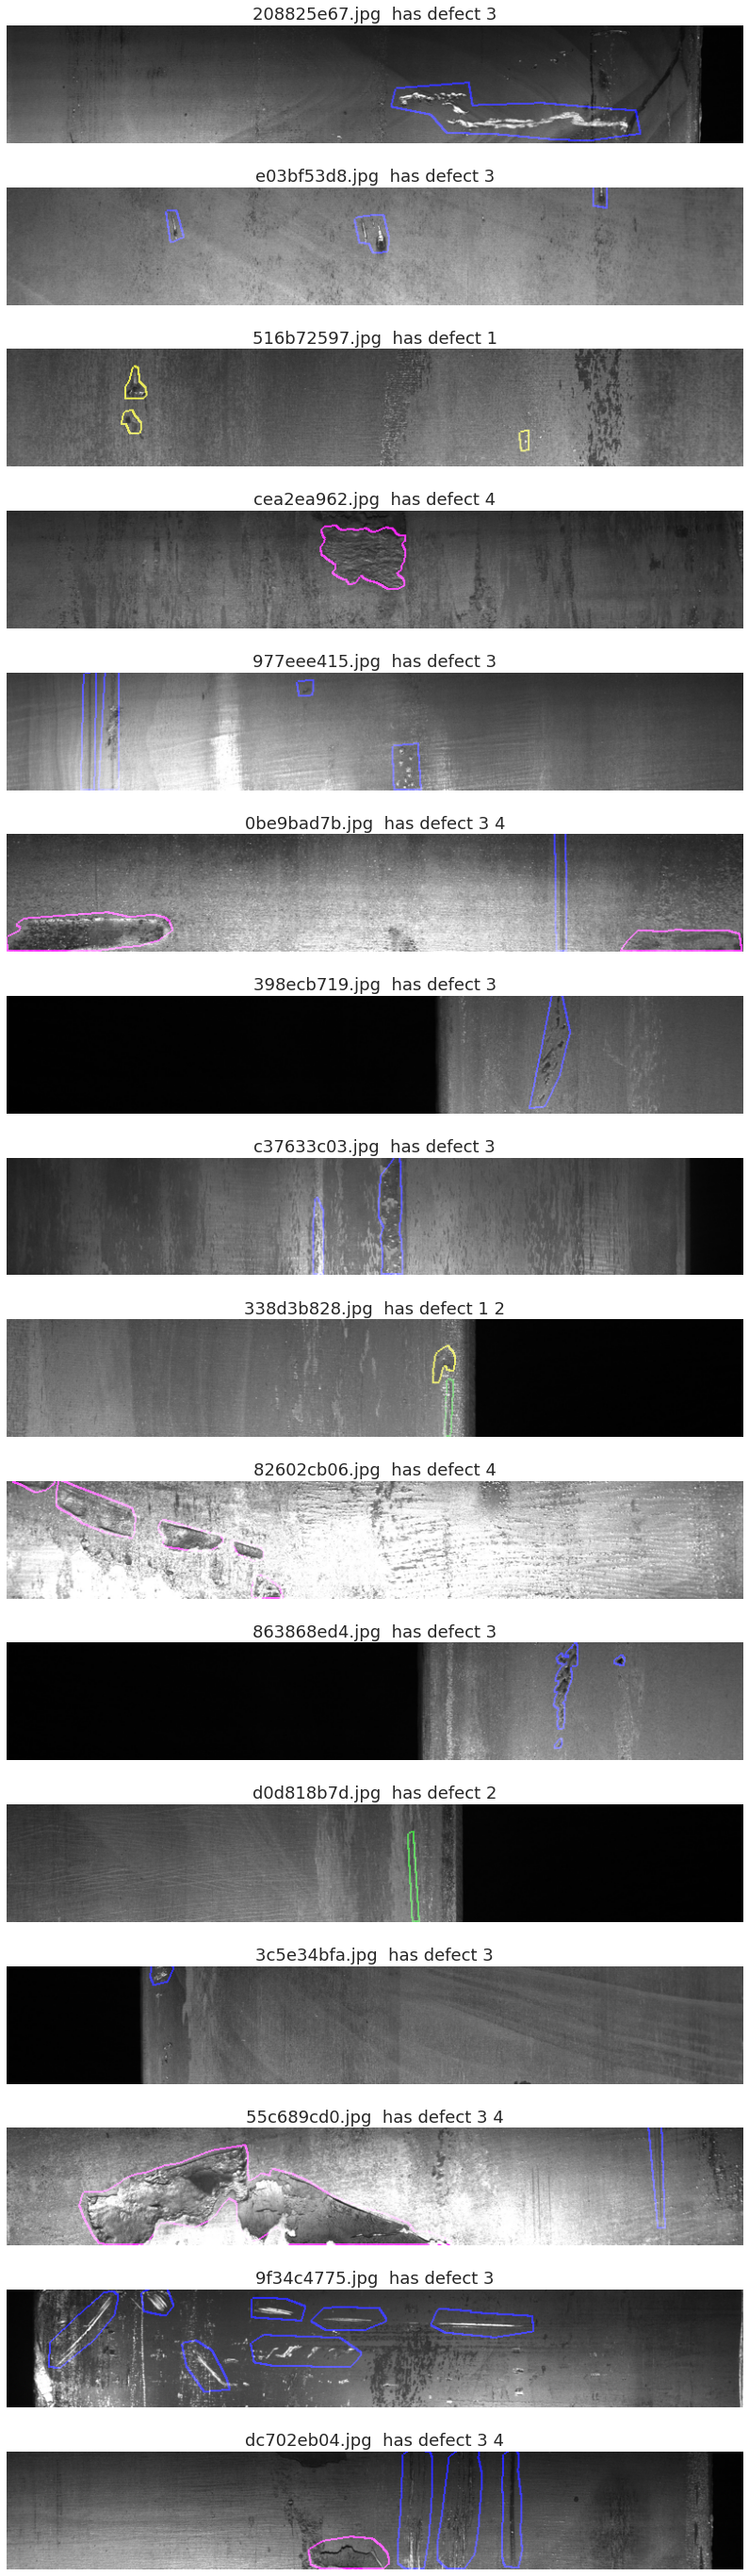

In [16]:
# DATA GENERATOR
train_batches = DataGenerator(train[train.index.isin(defects)],shuffle=True,info=filenames)
print('Images and masks from our Data Generator')
print('KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4')

# DISPLAY IMAGES WITH DEFECTS
for i,batch in enumerate(train_batches):
    plt.figure(figsize=(14,50)) #20,18
    for k in range(16):
        plt.subplot(16,1,k+1)
        img = batch[0][k,]
        img = Image.fromarray(img.astype('uint8'))
        img = np.array(img)
        extra = '  has defect'
        for j in range(4):
            msk = batch[1][k,:,:,j]
            msk = mask2pad(msk,pad=3)
            msk = mask2contour(msk,width=2)
            if np.sum(msk)!=0: extra += ' '+str(j+1)
            if j==0: # yellow
                img[msk==1,0] = 235 
                img[msk==1,1] = 235
            elif j==1: img[msk==1,1] = 210 # green
            elif j==2: img[msk==1,2] = 255 # blue
            elif j==3: # magenta
                img[msk==1,0] = 255
                img[msk==1,2] = 255
        plt.title(filenames[16*i+k]+extra)
        plt.axis('off') 
        plt.imshow(img)
    plt.subplots_adjust(wspace=0.05)
    plt.show()

# Creating the Model

Here I will use a pretrained Keras UNET found [here](https://github.com/qubvel/segmentation_models) with a ResNet34 architecture and  . The authors provide different segmentation models with different architectures and pretrained backbones. The UNET-Encoder is pretrained, however, the decoder need to be additionally trained.The Encoder has a ResNet34 architecture with Imagenet pretrained weights.

The Loss function is the [Dice Coeffition of similarity](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) 

In [0]:
'''
TRY WITHOUT KERAS - ONLY TENSORFLOW
'''
from keras import backend as K

# Evaluation Metrics
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f*y_pred_f)
    return (2.*intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    

In [18]:
from segmentation_models import Unet
from segmentation_models import backbones
from segmentation_models import losses

preprocess = backbones.inception_resnet_v2
loss_func = losses.JaccardLoss(per_image=True)

model = Unet('resnet34', input_shape=(128, 800, 3), classes=4, activation='sigmoid')
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=[dice_coef]
)

Segmentation Models: using `keras` framework.
85524480/85521592 [==============================] - 6s 0us/step


In [0]:
def my_preprocess(x):
    return x-110

In [20]:
import time 
start_time = time.time()

# # TRAIN AND VALIDATE MODEL
idx = int(0.8*len(train)); print()
train_batches = DataGenerator(train.iloc[:idx],shuffle=True,preprocess=my_preprocess)
valid_batches = DataGenerator(train.iloc[idx:],preprocess=my_preprocess)

history = model.fit_generator(train_batches, 
                              validation_data = valid_batches,
                              epochs = 10, verbose=2,
                              use_multiprocessing=True,
                              workers=6)

model.save('/content/drive/My Drive/Colab Notebooks/Steel/unet7.h5')
historydf = pd.DataFrame(history.history)
historydf.to_csv(historydf.to_csv('/content/drive/My Drive/Colab Notebooks/Steel/history_unet7.csv', index=False))

end_time = time.time()
# Print elapsed time
time_elapsed = end_time - start_time
print(time_elapsed)


Epoch 1/10

Epoch 1/10
 - 148s - loss: 0.0911 - dice_coef: 0.2241 - val_loss: 0.0479 - val_dice_coef: 0.4249
Epoch 2/10
Epoch 2/10
 - 129s - loss: 0.0310 - dice_coef: 0.4323 - val_loss: 0.0291 - val_dice_coef: 0.4883
 - 148s - loss: 0.0911 - dice_coef: 0.2241 - val_loss: 0.0479 - val_dice_coef: 0.4249
Epoch 3/10
 - 130s - loss: 0.0281 - dice_coef: 0.4829 - val_loss: 0.0284 - val_dice_coef: 0.4530
Epoch 3/10
Epoch 4/10
Epoch 4/10
 - 129s - loss: 0.0269 - dice_coef: 0.5022 - val_loss: 0.0312 - val_dice_coef: 0.5014
Epoch 5/10
 - 129s - loss: 0.0248 - dice_coef: 0.5340 - val_loss: 0.0267 - val_dice_coef: 0.5723
Epoch 6/10
 - 130s - loss: 0.0236 - dice_coef: 0.5516 - val_loss: 0.0268 - val_dice_coef: 0.5658
Epoch 6/10
Epoch 7/10
 - 130s - loss: 0.0232 - dice_coef: 0.5588 - val_loss: 0.0260 - val_dice_coef: 0.5454
Epoch 8/10
Epoch 8/10
 - 129s - loss: 0.0215 - dice_coef: 0.5845 - val_loss: 0.0258 - val_dice_coef: 0.5511
Epoch 9/10
 - 129s - loss: 0.0223 - dice_coef: 0.5749 - val_loss: 0.02

In [0]:
# Saving and Loading
# from keras.models import load_model

In [0]:
# model = load_model('/content/drive/My Drive/Colab Notebooks/Steel/unet5.h5', custom_objects={'dice_coef': dice_coef})

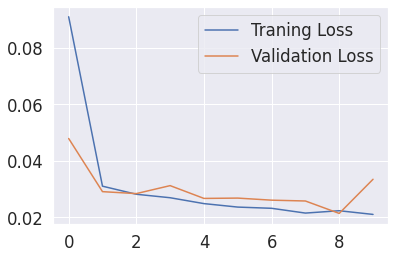

In [21]:
# history = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Steel/history_unet4.csv')
# Results
plt.plot(historydf['loss'], label='Traning Loss')
plt.plot(historydf['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

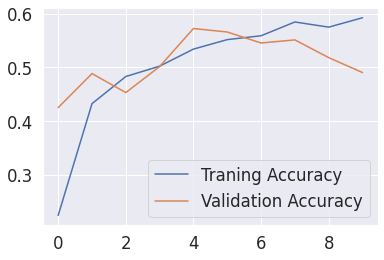

In [23]:
plt.plot(historydf['dice_coef'], label='Traning Accuracy')
plt.plot(historydf['val_dice_coef'], label='Validation Accuracy')
plt.legend()
plt.show()

The Loss seams to converge both for the Training and for the Test set. The Dice Coefficient seams to had a pick at the forth epoch. 

First, I would let train the model a bit longer. It is important to see how the loss will be with more epochs and when the convergence slows down or stop for the Training and Validation set and at which point we are starting to overfit.

Second, comments in Kaggle suggest that the metrics is not accuaratelly formulated.



In [0]:
model.summary()

In [0]:
tf.keras.utils.plot_model(model, show_shapes=True)

# Prediction EDA

Lets take some examples from the validation set and see how the models predict them.

In [24]:
idx = int(0.8*len(train)); print()
val_set = train.iloc[idx:]

defects = list(val_set[val_set['e1']!=''].sample(6).index)
defects += list(val_set[val_set['e2']!=''].sample(6).index)
defects += list(val_set[val_set['e3']!=''].sample(14).index)
defects += list(val_set[val_set['e4']!=''].sample(8).index)

In [25]:
len(defects)

34

In [0]:
valid_batches = DataGenerator(val_set[val_set.index.isin(defects)], preprocess=my_preprocess)

In [27]:
valid_batches.indexes

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

In [28]:
val_set[val_set.index.isin(defects)].head()

ImageId  ... count
5435  cf48232c6.jpg  ...     2
5451  d01d3e444.jpg  ...     1
5472  d10c885f3.jpg  ...     1
5613  d65fc70b5.jpg  ...     1
5656  d7a966551.jpg  ...     1

[5 rows x 6 columns]

In [29]:
preds = model.predict_generator(valid_batches, verbose=1)

2/2 [==============================] - 1s 690ms/step


## Plot Predictions

In [30]:
# The result are 32 images with 4 masks
print(preds.shape)
print(preds[0].min())
print(preds[0].max())
print()
i = 4
print(preds[i,:,:,0].mean())
print(preds[i,:,:,1].mean())
print(preds[i,:,:,2].mean())
print(preds[i,:,:,3].mean())

(32, 128, 800, 4)
5.696101e-08
0.988472

7.043745e-05
0.00015862664
0.0033996343
5.4157794e-05


Plotting predictions...
KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4


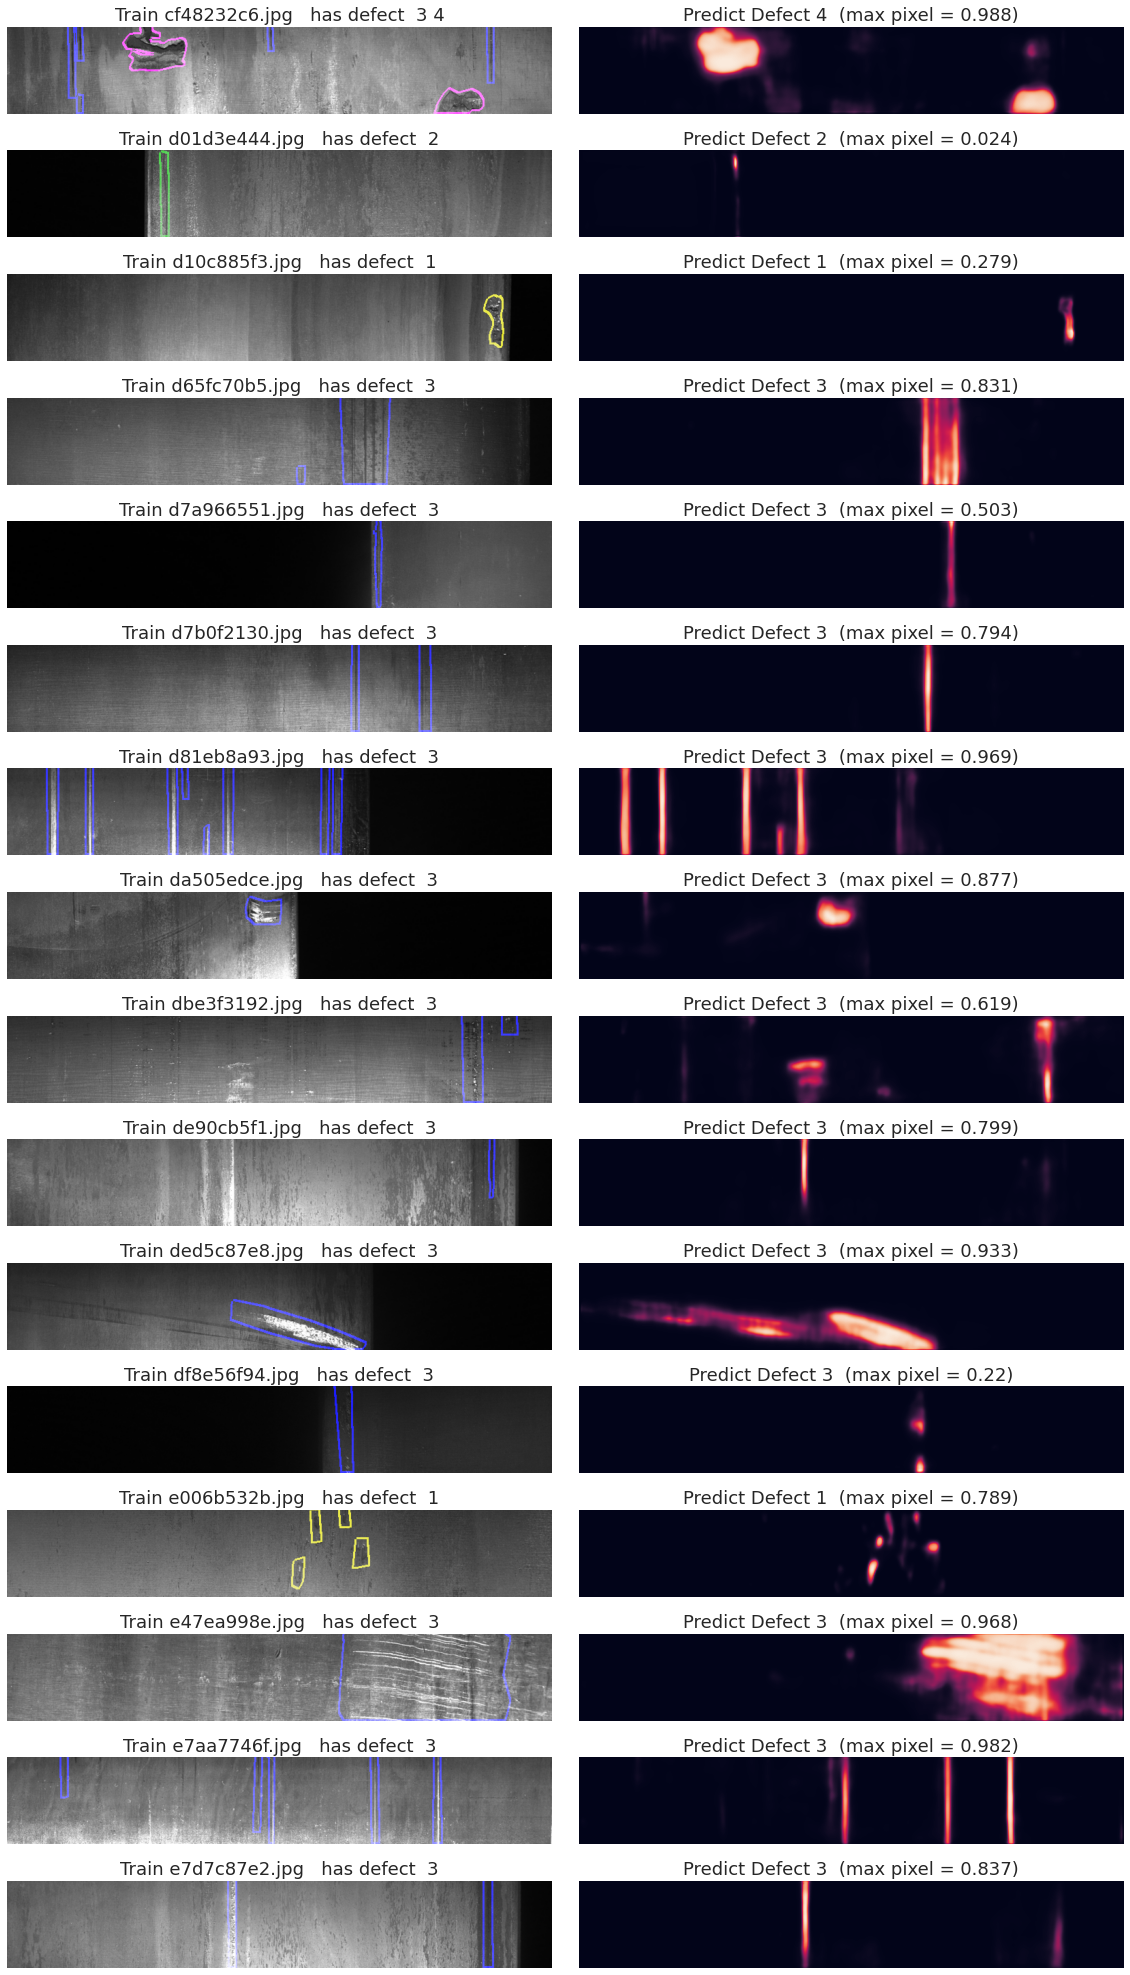

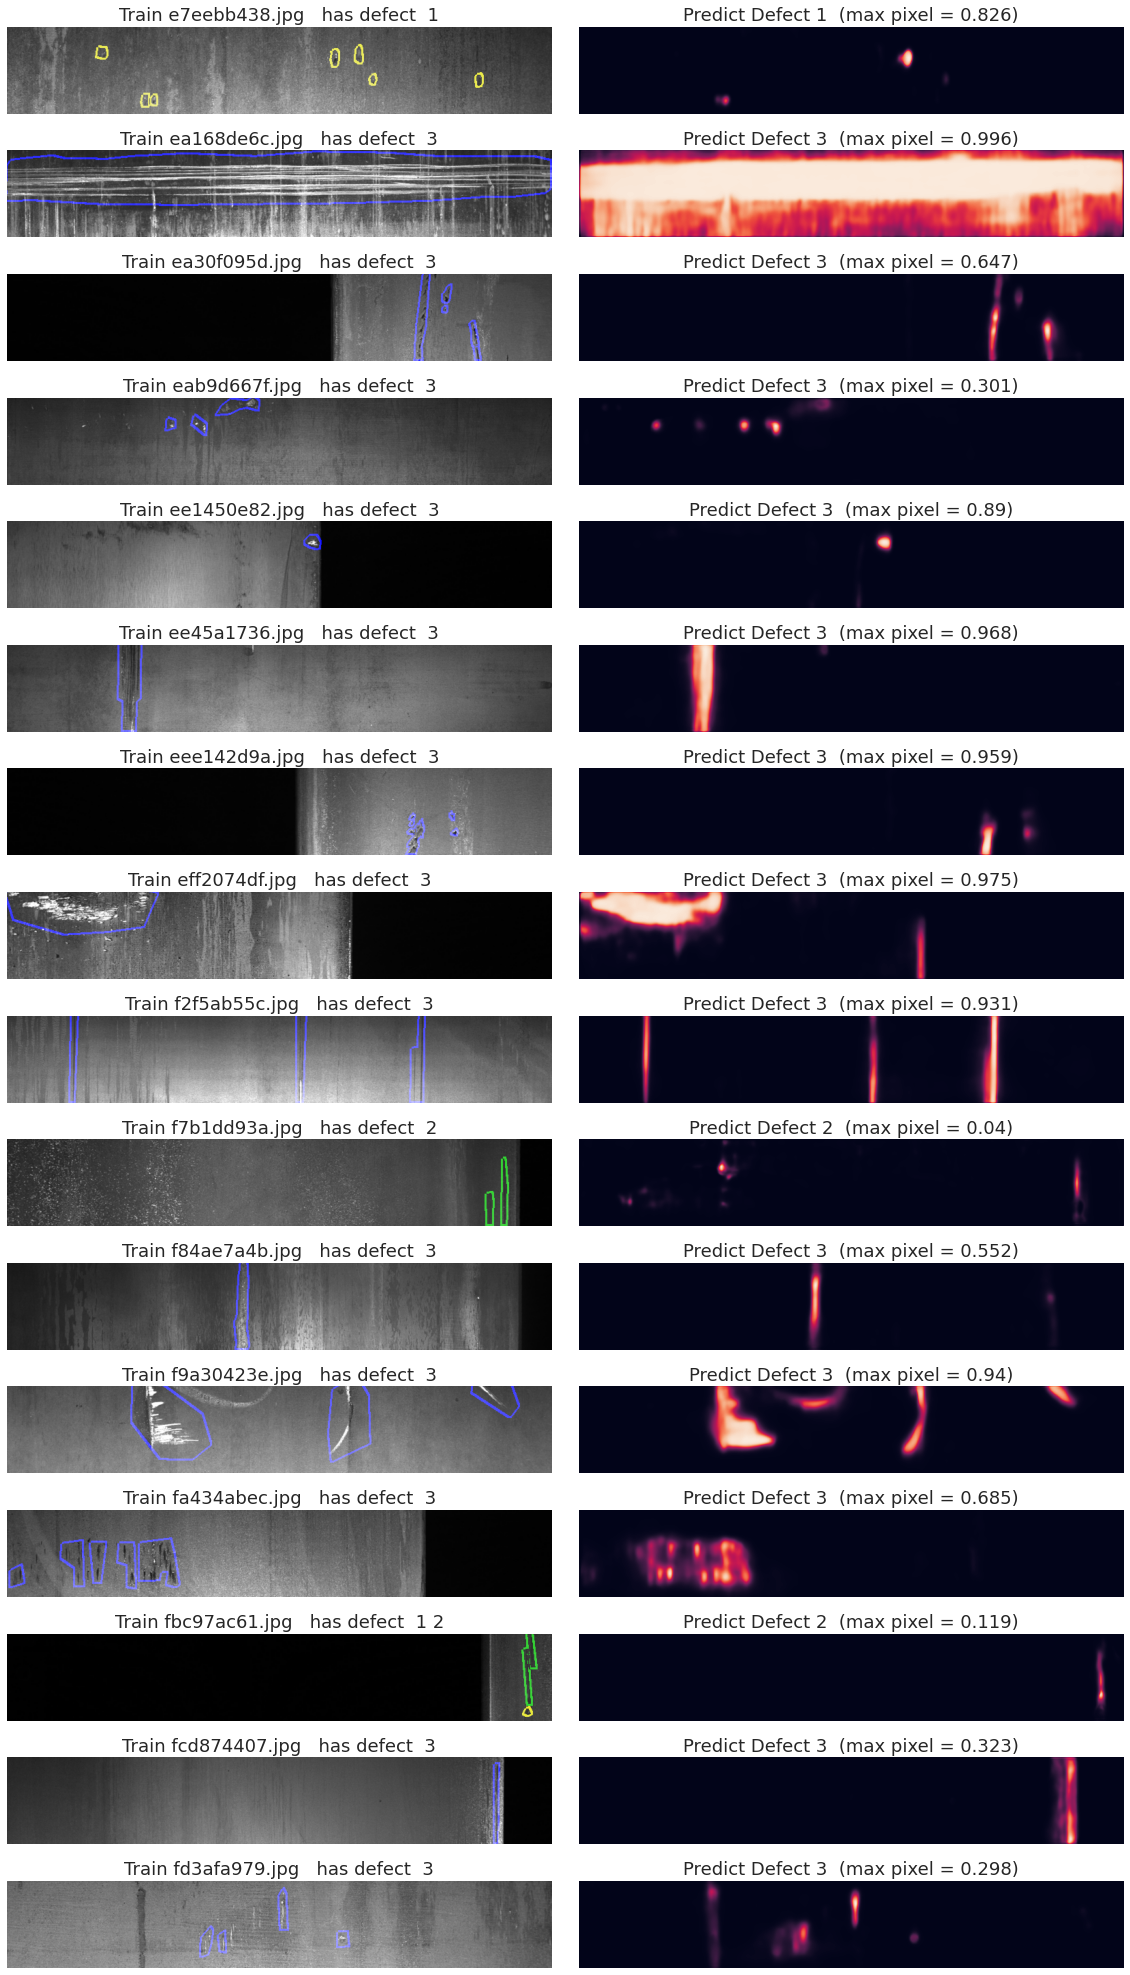

In [31]:
val_set1 = val_set[val_set.index.isin(defects)]
validation_batches = DataGenerator(val_set1)
print('Plotting predictions...')
print('KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4')

for i, batch in enumerate(validation_batches):
  plt.figure(figsize=(20, 36))
  for k in range(16):
    plt.subplot(16, 2, 2*k+1) # what is the 3d argument??
    img = batch[0][k,] # batch[0] is the image, [1] the mask
    img = Image.fromarray(img.astype('uint8'))
    img = np.array(img) # Why is this needed

    
    dft = 0
    extra = '   has defect '
    for j in range(4):
      msk = batch[1][k,:,:,j]
      if np.sum(msk)!=0:
        dft = j+1
        extra += ' '+str(j+1)
      msk = mask2pad(msk, pad=2)
      msk = mask2contour(msk, width=3)
      if j==0: # yellow
          img[msk==1,0] = 235 
          img[msk==1,1] = 235
      elif j==1: img[msk==1,1] = 210 # green
      elif j==2: img[msk==1,2] = 255 # blue
      elif j==3: # magenta
          img[msk==1,0] = 255
          img[msk==1,2] = 255

    if extra=='  has defect ': extra ='' # Why is this???
    plt.title('Train ' + val_set1.iloc[16*i+k,0]+extra)
    plt.axis('off') 
    plt.imshow(img)
    plt.subplot(16,2,2*k+2)
    if dft!=0:
      msk = preds[16*i+k,:,:,dft-1]
      plt.imshow(msk)
    else:
      plt.imshow(np.zeros((128,800)))
    plt.axis('off')
    mx = np.round(np.max(msk), 3)
    plt.title('Predict Defect '+str(dft)+'  (max pixel = '+str(mx)+')')
  plt.subplots_adjust(wspace=0.05)
  plt.show()

Although the model has been trained on just 10 epochs, it converges based on the choosen loss function in the Train and in the Validation set. Choosing a threshold (certainty of the model to have detected a defect of a certain type in a single pixel) is a todo for a future work. However, with a threshold of 50% 2/3 of the samples were correctyl identified and classified.

### ERROR EDA 1

The masks above look pretty good. But note that we are only plotting masks corresponding to defects that are present. Below, regardless of what type of defect an image has, we will plot the defect 3 mask. Only the blue contour lines on the left are defect 3. So when we see contours on the left that do not include blue, we should not see defect 3 masks but we still do.

In [32]:
val_set2 = val_set[(val_set['count']!=0)&(val_set['e3'].isnull())].sample(35)

valid_batches = DataGenerator(val_set2, preprocess=my_preprocess)
preds = model.predict_generator(valid_batches, verbose=1)

2/2 [==============================] - 1s 266ms/step


In [34]:
val_set2.head()

ImageId  ... count
5682  d8a7f9cab.jpg  ...     1
5490  d1aaada08.jpg  ...     1
6625  fe8e137c0.jpg  ...     1
5391  ce02060b9.jpg  ...     1
5919  e29a708e0.jpg  ...     1

[5 rows x 6 columns]

Plotting predictions...
KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4


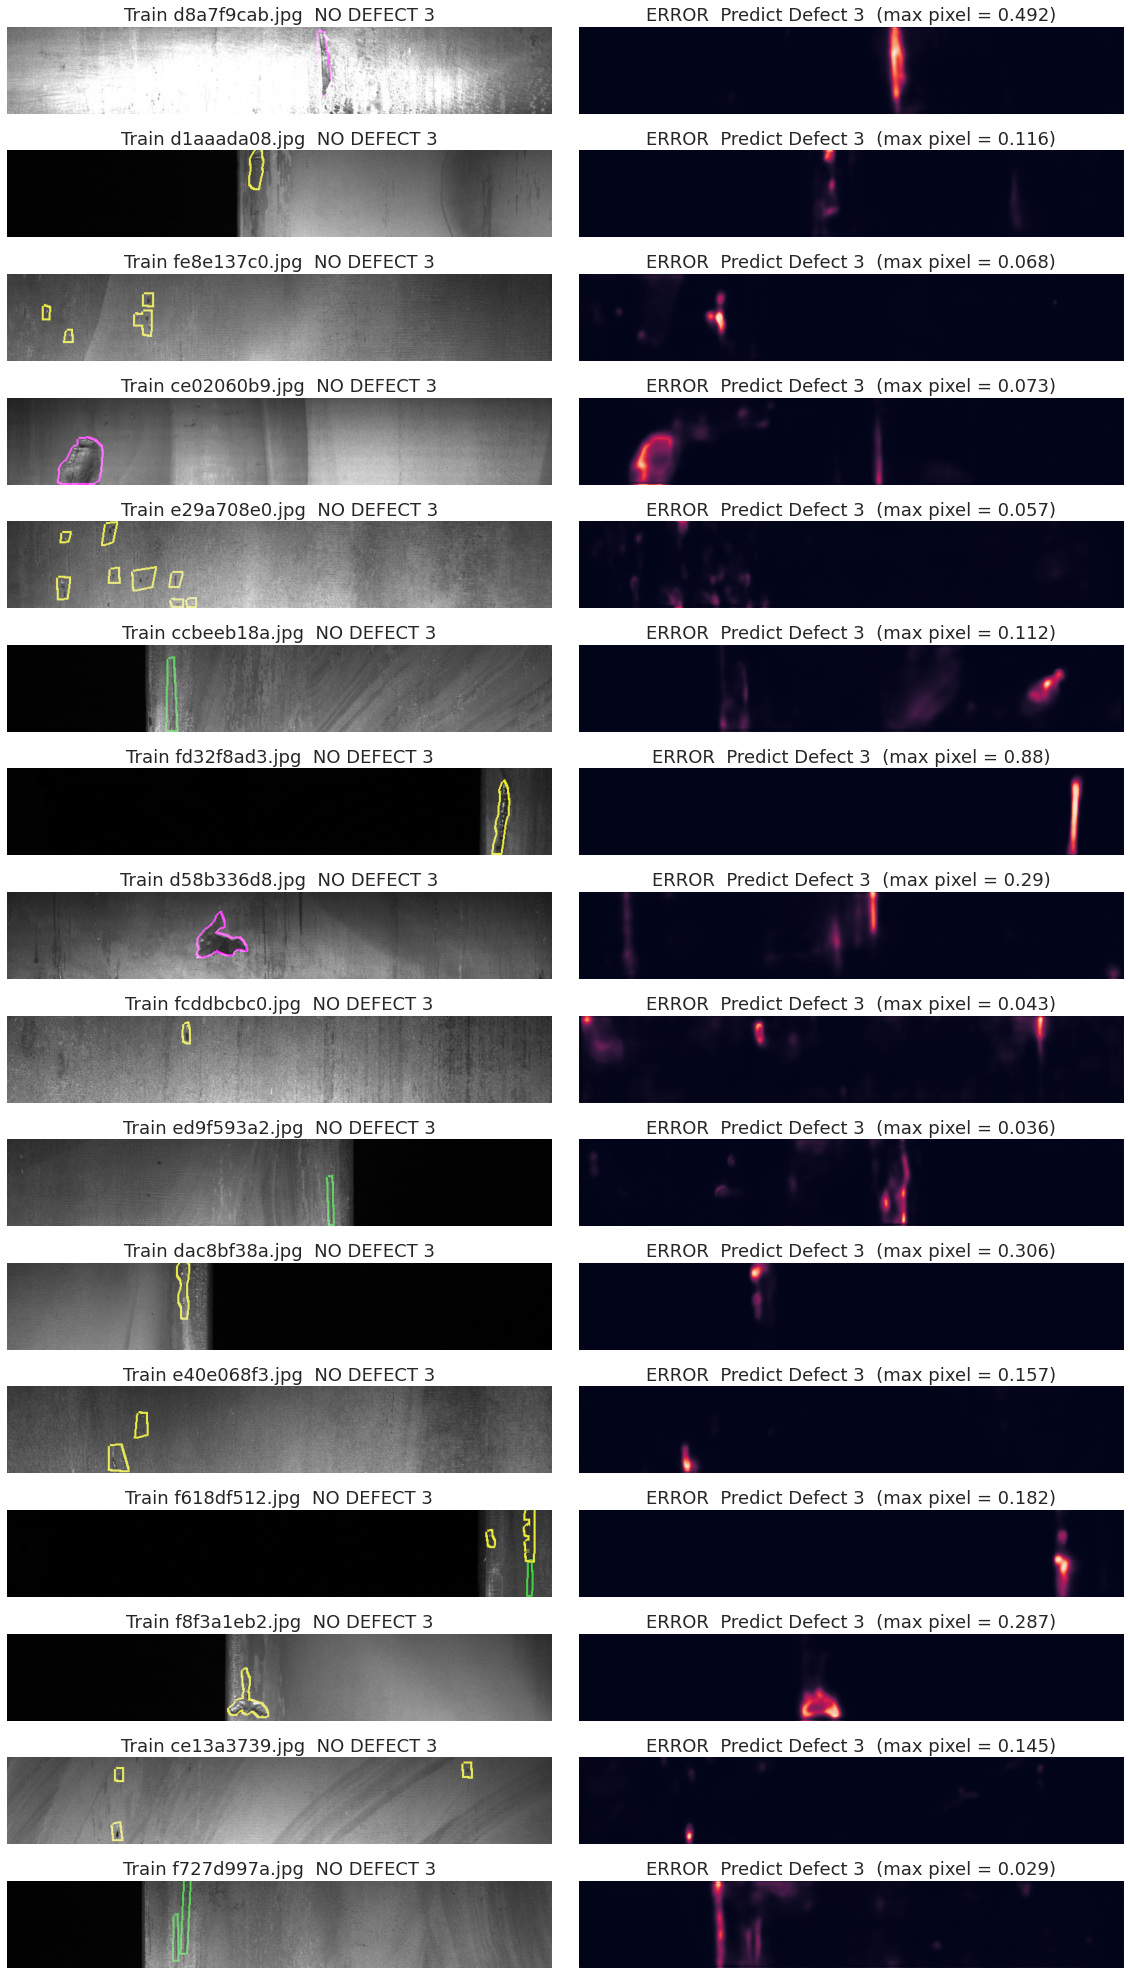

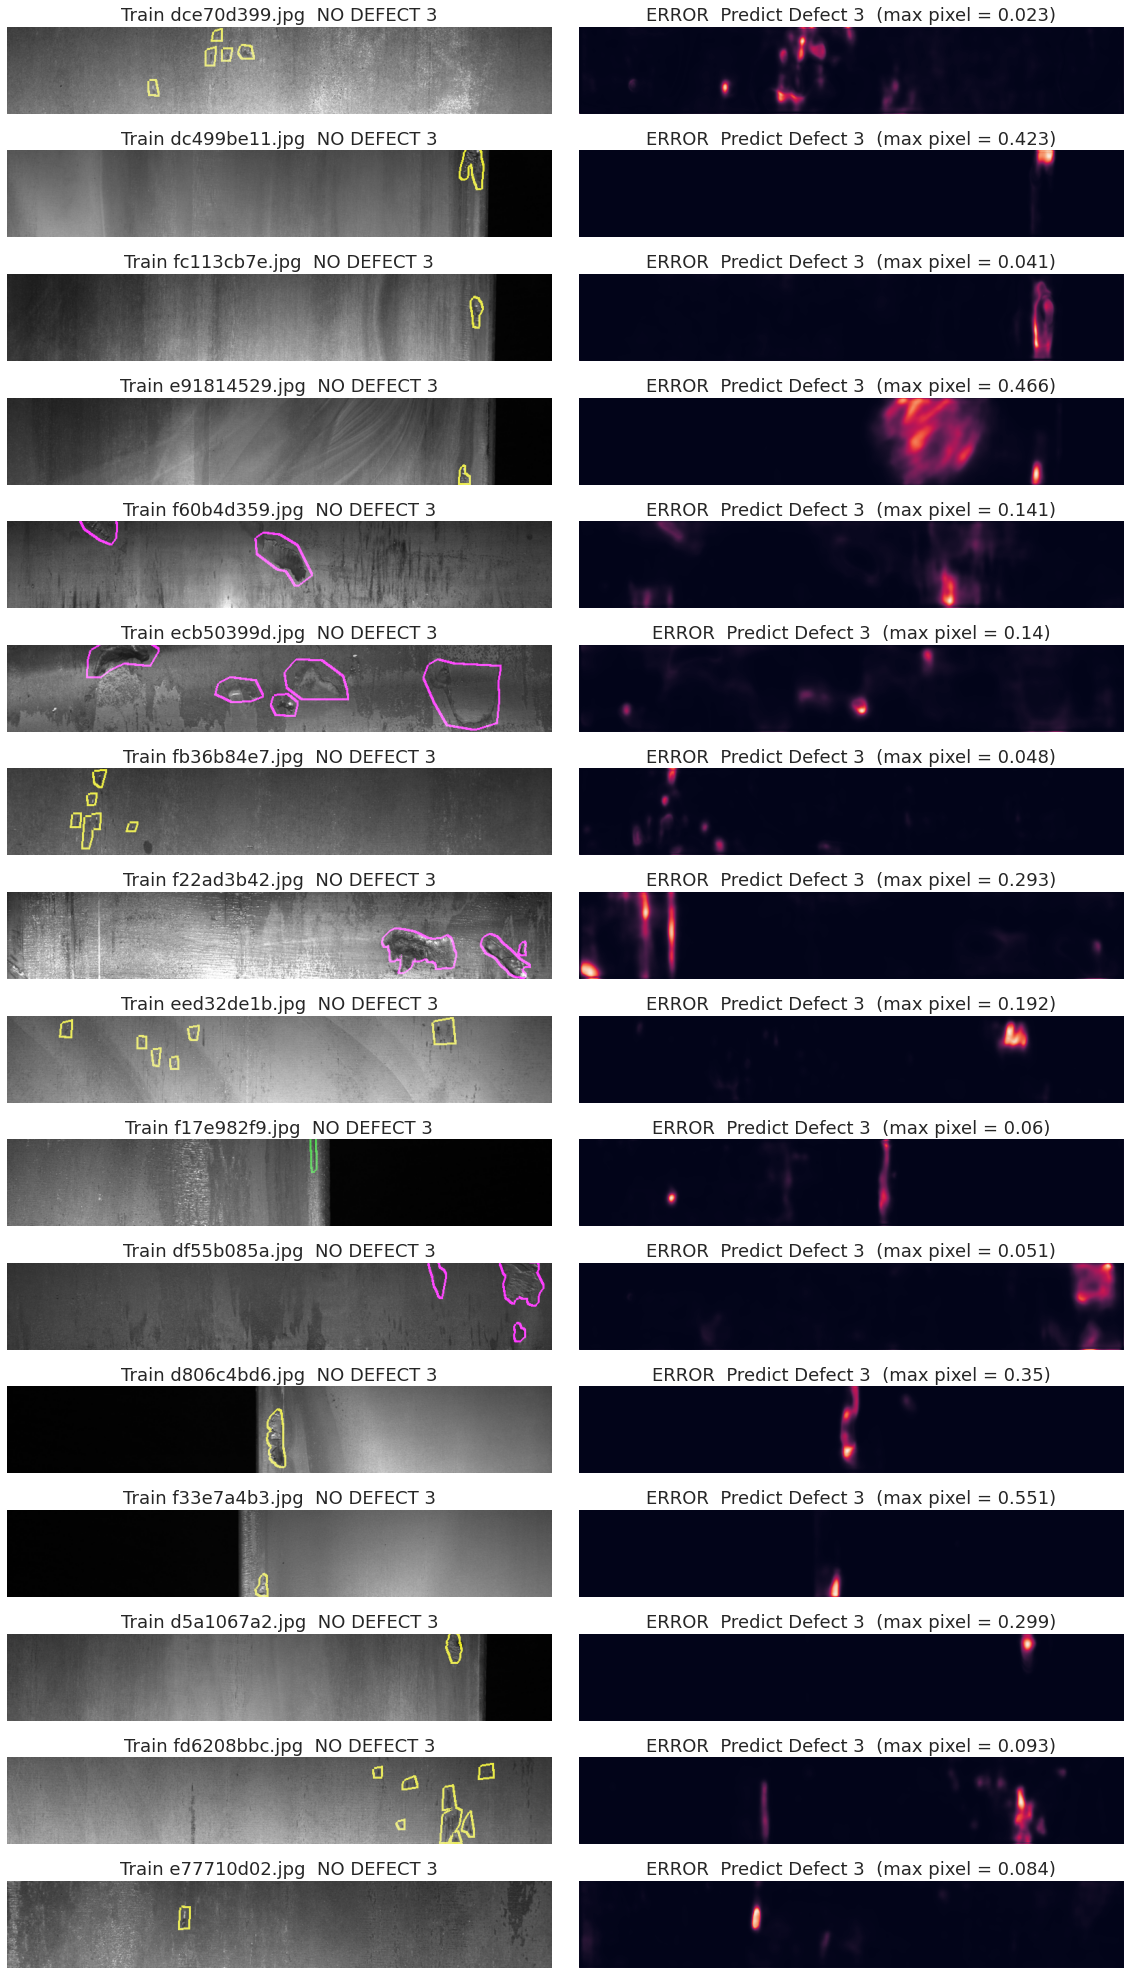

In [35]:
validation_batches = DataGenerator(val_set2)
print('Plotting predictions...')
print('KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4')

for i, batch in enumerate(validation_batches):
  plt.figure(figsize=(20, 36))
  for k in range(16):
    plt.subplot(16, 2, 2*k+1) # what is the 3d argument??
    img = batch[0][k,] # batch[0] is the image, [1] the mask
    img = Image.fromarray(img.astype('uint8'))
    img = np.array(img) # Why is this needed

    
    dft = 0
    three = False
    for j in range(4):
      msk = batch[1][k,:,:,j]
      if np.sum(msk)!=0:
        dft = j+1
        extra += ' '+str(j+1)
      msk = mask2pad(msk, pad=2)
      msk = mask2contour(msk, width=3)
      if j==0: # yellow
          img[msk==1,0] = 235 
          img[msk==1,1] = 235
      elif j==1: img[msk==1,1] = 210 # green
      elif j==2: img[msk==1,2] = 255 # blue
      elif j==3: # magenta
          img[msk==1,0] = 255
          img[msk==1,2] = 255
    extra = ''; extra2 = ''
    if not three:
      extra = '  NO DEFECT 3'
      extra2 = 'ERROR  '
    plt.title('Train ' + val_set2
              .iloc[16*i+k,0]+extra)
    plt.axis('off') 
    plt.imshow(img)
    plt.subplot(16,2,2*k+2)
    dft=3
    if dft!=0:
      msk = preds[16*i+k,:,:,dft-1]
      plt.imshow(msk)
    else:
      plt.imshow(np.zeros((128,800)))
    plt.axis('off')
    mx = np.round(np.max(msk), 3)
    plt.title(extra2 + 'Predict Defect '+str(dft)+'  (max pixel = '+str(mx)+')')
  plt.subplots_adjust(wspace=0.05)
  plt.show()

The maximum pixel value could be interpreted as the model certainty about detecting the error type. From the abouve 32 samples, only in 2 cases the model gave more then 50% certanty of detecting Error #3. This could be considered not a bad result when having a 50% threshold.

So the next step would be to inspect where is the right threshold to sed for model certainty. 

